# Messages throughput

In this notebook, we do an analysis of the average amount of messages we get to send compressed per second for a worst case scenario of a payload with a high entropy composed of random numbers.

These tests have been run by building the code from https://github.com/eclipse-zenoh/zenoh/compare/master...DariusIMP:zenoh:compression_measurements?expand=1 which contains the latest version from the branch compression of zenoh and with master having been merged into this branch. In that dummy branch we edit the code in order to print for instance batch sizes, and altered the z_pub_thr test to modify the contents of the messages with random numbers, simulating high entropy messages which are difficult to compress.

To build zenoh, you can run
```
cargo build --all-targets --release --features transport_compression,unstable
```


For this we ran as a publisher:
```
 ./target/release/examples/z_pub_thr 8 -m peer -c test.json5 --high-entropy --no-multicast-scouting -e tcp/127.0.0.1:7447
```
and as a receiver
```
./target/release/examples/z_sub_thr -m peer --no-multicast-scouting -l tcp/127.0.0.1:7447 -n 10000 -s 1000
```

varying the size of the messages size from 8 bytes to 63KB. For 64KB message size an error occurs that is yet to be determined what happened (something related to the orchestrator).

A python script was used to generate all the output results, which can be found on this repo under script.py:

In [108]:
cat ../script.py

import subprocess
import os

KB = 1024

SIZES = [8, 16, 32, 64, 128, 256, 512, KB, 2*KB, 4*KB, 8*KB, 16*KB, 24*KB, 32*KB, 40*KB, 48*KB, 56*KB, 63*KB]

def run_compression(compression_enabled, with_high_entropy = False):
    rcv_cmds = ["../zenoh/target/release/examples/z_sub_thr", "-m", "peer", "--no-multicast-scouting", "-l", "tcp/127.0.0.1:7447", "-n", "10000", "-s", "1000"]
    if compression_enabled:
        rcv_cmds.insert(3, "-c")
        rcv_cmds.insert(4, "compression_enabled.json5")
    for size in SIZES:
        send_cmds = ["../zenoh/target/release/examples/z_pub_thr", str(size), "-m", "peer", "--no-multicast-scouting", "-e", "tcp/127.0.0.1:7447"]
        if compression_enabled:
            send_cmds.insert(4, "-c")
            send_cmds.insert(5, "compression_enabled.json5")
            
            if (with_high_entropy):
                send_cmds.insert(6, "--high-entropy")
        

        path = "output_64"
        if compression_enabled:
            path += "/compress

Where in test.json5 we enable the compression.

In [109]:
import pandas as pd
import matplotlib.pyplot as plt


To enable the compression, we use the config "compression_enabled.json5"

In [125]:
cat ../compression_enabled.json5

/// Configure internal transport parameters
{
  transport: {
    link: {
      compression: {
        /// When is_enabled is true, batches will be sent compressed. It does not affect the
        /// reception, which always expects compressed batches when built with the feature
        /// "transport_compression".
        enabled: true,
      },
    },
  },
}


In [110]:
KB = 1024
SIZES = [8, 16, 32, 64, 128, 256, 512, KB, 2*KB, 4*KB, 8*KB, 16*KB, 24*KB, 32*KB, 40*KB, 48*KB, 56*KB, 63*KB]

In [111]:
def parse_file(filename):
    file = open(filename, 'r')
    lines = file.readlines()
    measurements = []
    for line in lines:
        measurement = line.strip(' msg/s\n')
        measurements = measurements + [float(measurement)]
    return measurements
        

In [112]:
def parse_batch_size_file(filename):
    file = open(filename, 'r')
    lines = file.readlines()
    measurements = []
    count = 0
    for line in lines:
        measurement = line.strip(' bytes\n')
        measurements = measurements + [int(measurement)]
        count = count + 1
        if count > 500:
            break
    return measurements
        

In [113]:
import numpy as np

In [114]:
averages_low_entropy = {}
averages_high_entropy = {}
averages_uncompressed = {}
for size in SIZES:
    averages_uncompressed[size] = np.average(parse_file('../output/compression_disabled/compression_logs/compression_' + str(size) + '.txt'))
    averages_low_entropy[size] = np.average(parse_file('../output/compression_enabled/low_entropy/compression_logs/compression_' + str(size) + '.txt'))
    averages_high_entropy[size] = np.average(parse_file('../output/compression_enabled/high_entropy/compression_logs/compression_' + str(size) + '.txt'))

print(averages_uncompressed)
print(averages_low_entropy)
print(averages_high_entropy)

{8: 5438335.863288455, 16: 5317652.1761067705, 32: 5464540.411061123, 64: 5304919.970245249, 128: 4959176.356897409, 256: 4525223.472832913, 512: 3960372.12476685, 1024: 3521425.9421416754, 2048: 2676916.322966819, 4096: 1694640.2844267774, 8192: 739162.8879037175, 16384: 334756.09019610565, 24576: 222848.815694133, 32768: 134639.46600928376, 40960: 126491.38181426124, 49152: 112194.19992564083, 57344: 107473.44673395553, 64512: 102049.56880744078}
{8: 5125759.080527643, 16: 5253247.981499054, 32: 5283645.731790324, 64: 5276475.12603676, 128: 5120217.26768663, 256: 4751056.8090550415, 512: 4102484.076824672, 1024: 3393521.784595026, 2048: 2427751.7374090576, 4096: 1647437.7272565807, 8192: 746097.1262787179, 16384: 279351.12522059993, 24576: 155265.98603005885, 32768: 66276.58420709702, 40960: 59837.54175863274, 49152: 51456.5634481155, 57344: 44991.31929304945, 64512: 42210.60368210061}
{8: 5027605.244532706, 16: 5174660.093507143, 32: 5227608.275666102, 64: 5204532.623830602, 128: 51

In [115]:
batch_sizes_low_entropy = {}
batch_sizes_high_entropy = {}
for size in SIZES:
    batch_sizes_low_entropy[size] = np.average(parse_batch_size_file('../output/compression_enabled/low_entropy/batch_sizes/batch_size_' + str(size) + '.txt'))
    batch_sizes_high_entropy[size] = np.average(parse_batch_size_file('../output/compression_enabled/high_entropy/batch_sizes/batch_size_' + str(size) + '.txt'))

print(batch_sizes_high_entropy)
print(batch_sizes_low_entropy)

{8: 239.50898203592814, 16: 244.6986027944112, 32: 246.0758483033932, 64: 285.3552894211577, 128: 386.20958083832335, 256: 518.0239520958083, 512: 779.249500998004, 1024: 1299.8223552894212, 2048: 2305.880239520958, 4096: 4353.309381237525, 8192: 8423.56886227545, 16384: 16571.52894211577, 24576: 24747.17764471058, 32768: 32719.233532934133, 40960: 40894.882235528945, 49152: 49070.53093812375, 57344: 57246.17964071856, 64512: 64399.87225548902}
{8: 255.5888223552894, 16: 241.5568862275449, 32: 263.72654690618765, 64: 267.11976047904193, 128: 228.44111776447104, 256: 282.42914171656685, 512: 284.63473053892216, 1024: 292.5988023952096, 2048: 288.6047904191617, 4096: 280.88423153692617, 8192: 265.14171656686625, 16384: 234.20359281437126, 24576: 233.40518962075848, 32768: 166.33932135728543, 40960: 198.2754491017964, 49152: 230.2115768463074, 57344: 262.14770459081836, 64512: 290.0918163672655}


In [116]:
df_low_entropy = pd.DataFrame(averages_low_entropy.items())
df_high_entropy = pd.DataFrame(averages_high_entropy.items())
df_uncompressed = pd.DataFrame(averages_uncompressed.items())

In [117]:
df_batch_size_low_entropy = pd.DataFrame(batch_sizes_low_entropy.items())
df_batch_size_high_entropy = pd.DataFrame(batch_sizes_high_entropy.items())

In [118]:
df_low_entropy

,0,1
0,8,5.125759e+06
1,16,5.253248e+06
2,32,5.283646e+06
3,64,5.276475e+06
4,128,5.120217e+06
5,256,4.751057e+06
6,512,4.102484e+06
7,1024,3.393522e+06
8,2048,2.427752e+06
9,4096,1.647438e+06


In [119]:
df_high_entropy

,0,1
0,8,5.027605e+06
1,16,5.174660e+06
2,32,5.227608e+06
3,64,5.204533e+06
4,128,5.150043e+06
5,256,4.755085e+06
6,512,3.929211e+06
7,1024,3.250259e+06
8,2048,2.143248e+06
9,4096,1.235177e+06


In [120]:
df_uncompressed

,0,1
0,8,5.438336e+06
1,16,5.317652e+06
2,32,5.464540e+06
3,64,5.304920e+06
4,128,4.959176e+06
5,256,4.525223e+06
6,512,3.960372e+06
7,1024,3.521426e+06
8,2048,2.676916e+06
9,4096,1.694640e+06


In [121]:
def plot_messages_per_second():
    fig, ax = plt.subplots()

    ax.plot(df_low_entropy[0], df_low_entropy[1], label="Compressed: Low entropy", marker='o')
    ax.plot(df_high_entropy[0], df_high_entropy[1], label="Compressed: High entropy", marker='o')
    ax.plot(df_uncompressed[0], df_uncompressed[1], label="Uncompressed", marker='o')

    ax.set_xticks(df_low_entropy[0])
    ax.set_ylabel('Msgs/s')
    ax.set_xlabel('Message size')
    ax.set_xscale('log')
    ax.set_title('Average messages per second depending on the size of the message with compression with a low entropy payload')
    ax.grid(True)
    ax.legend(loc='center right', ncols=1)
    fig.set_figwidth(15)
    plt.show()


In [122]:
def plot_batch_sizes():
    fig, ax = plt.subplots()

    ax.plot(df_batch_size_low_entropy[0], df_batch_size_low_entropy[1], label="Compressed: Low entropy", marker='o')
    ax.plot(df_batch_size_high_entropy[0], df_batch_size_high_entropy[1], label="Compressed: High entropy", marker='o')
    ax.set_xticks(df_low_entropy[0])
    ax.set_ylabel('Msgs/s')
    ax.set_xlabel('Message size')
    ax.set_xscale('log')
    ax.set_title('Batch sizes')
    ax.grid(True)
    ax.legend(loc='center right', ncols=1)
    fig.set_figwidth(15)
    plt.show()


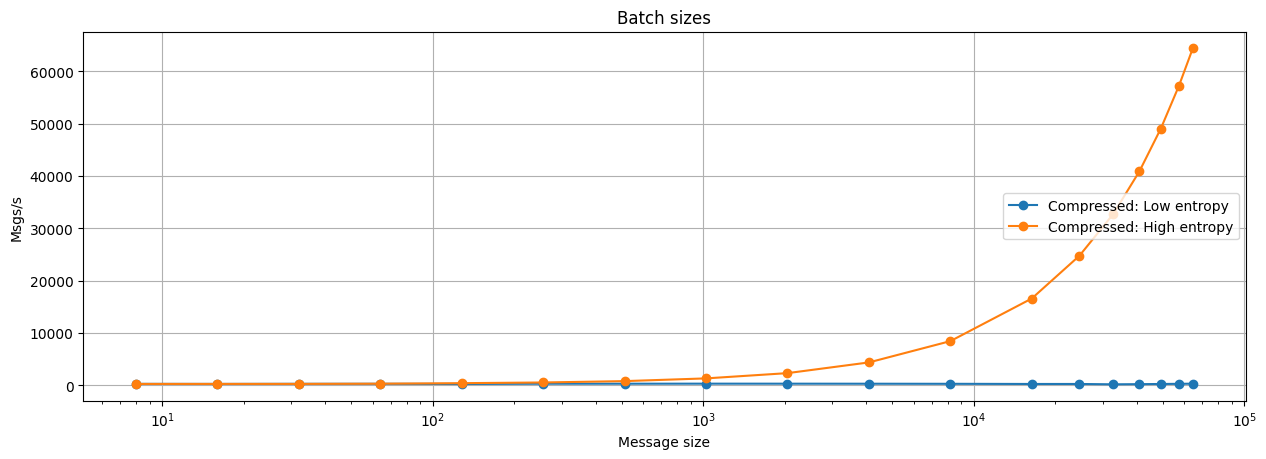

In [123]:
plot_batch_sizes()

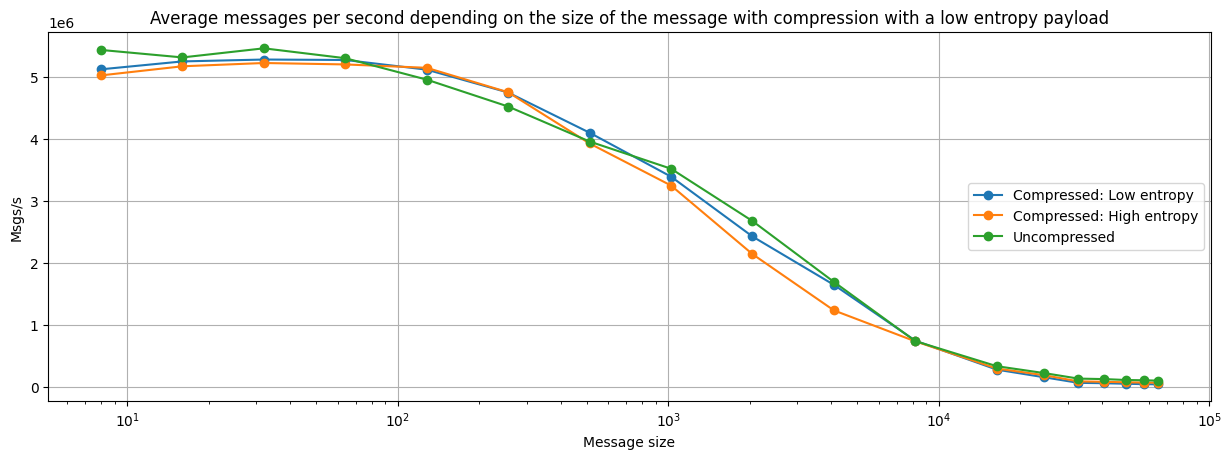

In [124]:
plot_messages_per_second()